In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST, FashionMNIST ,CIFAR10
from torchvision.models import resnet18
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
from vos import VOS

# Load ID (MNIST) and OOD (Fashion MNIST) datasets

In [2]:
id_dataset = MNIST(root = "~/datasets/MNIST", train = True)
ood_dataset = FashionMNIST(root = "~/datasets/FashionMNIST", train = True)
transform = Compose([lambda x: x.float(), Normalize((0.1307,), (0.3081,))])

samples = id_dataset.data
targets = id_dataset.targets
id_data = TensorDataset(transform(samples).unsqueeze(1), targets)

ood_samples = ood_dataset.data
ood_targets = ood_dataset.targets
ood_data = TensorDataset(transform(ood_samples).unsqueeze(1), ood_targets)

id_loader = DataLoader(id_data, batch_size = 64, shuffle = True)
ood_loader = DataLoader(ood_data, batch_size = 64, shuffle = True)

In [3]:
model = torch.load("vos_model.pt", weights_only = False)

In [4]:
class OODDetector(nn.Module):
    def __init__(self, latent_dim = 512):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = nn.Sequential(nn.Linear(1, latent_dim),
                                 nn.ReLU(),
                                 nn.Linear(latent_dim, 1),
                                 nn.ReLU())
    
    def forward(self, x):
        out = self.mlp(x)
        return out

In [5]:
ood_detector = torch.load("vos_ood_detector.pt", weights_only = False)

In [6]:
def accuracy(pred, true):
    return torch.sum(pred == true)/true.shape[0]

In [7]:
id_batch = next(iter(id_loader))
id_samples, id_targets = id_batch

# Model is pretty good at classification

In [8]:
pred = torch.argmax(model(id_samples), dim = 1)
true = id_targets
acc = accuracy(pred, true)
print(acc)

tensor(0.9531)


# Want to see that the ID and OOD samples have different probabilities. I need to work this out a little bit more, to make sure that it is doing what we want

In [9]:
id_logits = model(id_samples)
id_energy = -torch.logsumexp(id_logits, dim = 0).unsqueeze(1)
id_scores = ood_detector(id_energy)
id_prob = torch.exp(-id_scores)/(1 + torch.exp(-id_scores))
id_prob

tensor([[0.0005],
        [0.0353],
        [0.0274],
        [0.4302],
        [0.1397],
        [0.0270],
        [0.0435],
        [0.3001],
        [0.0046],
        [0.0074]], grad_fn=<DivBackward0>)

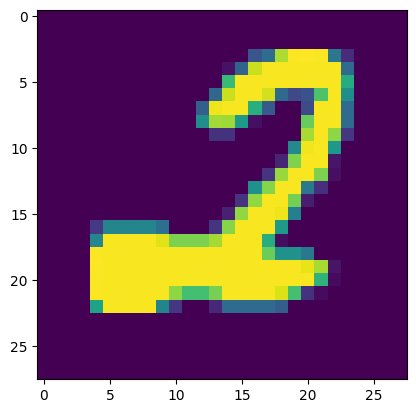

In [10]:
plt.imshow(id_samples[4][0])

In [11]:
ood_batch = next(iter(ood_loader))
ood_samples, ood_targets = ood_batch

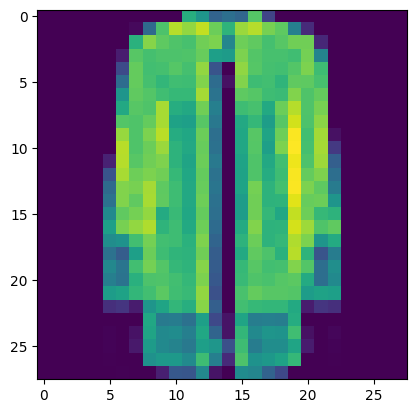

In [12]:
plt.imshow(ood_samples[3][0])

In [13]:
ood_logits = model(ood_samples)
ood_energy = -torch.logsumexp(ood_logits, dim = 0).unsqueeze(1)
ood_scores = ood_detector(ood_energy)
ood_prob = torch.exp(-ood_scores)/(1 + torch.exp(-ood_scores))
ood_prob

tensor([[0.5361],
        [0.4996],
        [0.4142],
        [0.2037],
        [0.3246],
        [0.5480],
        [0.5972],
        [0.2141],
        [0.4681],
        [0.2282]], grad_fn=<DivBackward0>)

In [14]:
id_scores

tensor([[7.6495],
        [3.3079],
        [3.5686],
        [0.2810],
        [1.8179],
        [3.5851],
        [3.0904],
        [0.8467],
        [5.3711],
        [4.9056]], grad_fn=<AddmmBackward0>)

In [15]:
ood_scores

tensor([[-0.1448],
        [ 0.0015],
        [ 0.3467],
        [ 1.3634],
        [ 0.7328],
        [-0.1924],
        [-0.3939],
        [ 1.3006],
        [ 0.1277],
        [ 1.2184]], grad_fn=<AddmmBackward0>)

# Want one group to be positive and the other negative. It seems that we have a definite difference in distribution, but we need to train a little longer, a little more stably, or something like that.

In [16]:
id_energy

tensor([[57.4689],
        [26.0270],
        [27.9122],
        [-4.8672],
        [15.2809],
        [28.0320],
        [24.4592],
        [ 8.2114],
        [40.9605],
        [37.5908]], grad_fn=<NegBackward0>)

In [17]:
ood_energy

tensor([[-1.4747],
        [-2.6767],
        [-5.3570],
        [11.9805],
        [ 7.3776],
        [ 1.6936],
        [ 0.5682],
        [11.5237],
        [-3.7096],
        [10.9247]], grad_fn=<NegBackward0>)